# Penerapan Analisis Regresi Linear Berganda

Kasus : Ingin diketahui apakah terdapat pengaruh Indeks Pembangunan Manusia (IPM) dan Tingkat Partisipasi Angkatan Kerja (TPAK) terhadap Jumlah Penduduk Miskin di Kabupaten/Kota di Jawa Timur. 

Data : Diambil dari website resmi BPS Jawa Timur.

Referensi : Dewanti, D. (2023). Metode Statistika Populer untuk Penelitian. Bogor: Exsight Analytics.



## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm #Modelling
from statsmodels.stats.descriptivestats import Description # descriptive statistics
from scipy.stats import shapiro # uji asumsi normalitas
from statsmodels.stats.diagnostic import het_breuschpagan # uji asumsi homoskedastisitas
from statsmodels.stats.stattools import durbin_watson # uji asumsi non-autokorelasi
from statsmodels.stats.outliers_influence import variance_inflation_factor # uji multikolinearitas

print('imported') # Checking

imported


## Definisikan fungsi

In [2]:
def compare(pvalue, alpha=0.05):
    if pvalue < alpha:
        return '{:.3f} < {}, H0 ditolak'.format(pvalue, alpha)
    else:
        return '{:.3f} > {}, H0 gagal ditolak'.format(pvalue, alpha)
    
def sign(num):
    return '-' if num < 0 else '+'

## Import Data

In [3]:
df = pd.read_csv('/kaggle/input/ipm-tpak-dan-penduduk-miskin-di-kabkot-jawa-timur/data.csv')
df.head(5)

,KaKot,JPM,IPM,TPAK
0,PACITAN,92800,64.92,80.64
1,PONOROGO,103220,68.16,70.24
2,TRENGGALEK,92170,67.25,74.43
3,TULUNGAGUNG,87370,70.07,69.63
4,BLITAR,114120,68.13,67.57


## EDA

### Deskriptif

In [4]:
Description(data=df).summary()

nobs,38.0,38.0,38.0
missing,0.0,0.0,0.0
mean,126048.68421052632,69.11315789473684,68.27131578947368
std_err,12576.133728978066,0.8768692778735043,0.5494245238468677
upper_ci,150697.45338408274,70.83179009851855,69.3481680684366
lower_ci,101399.9150369699,67.39452569095513,67.19446351051074
std,77524.49486212284,5.405385255296724,3.386880228376193
iqr,94272.5,7.362499999999997,3.6674999999999898
iqr_normal,69884.30882203468,5.457829416873745,2.71872181818464
mad,62120.78947368421,4.2954293628808875,2.4018421052631576
mad_normal,77856.86366856833,5.3835223463387285,3.0102626661259393


### Histogram dan distribusi data

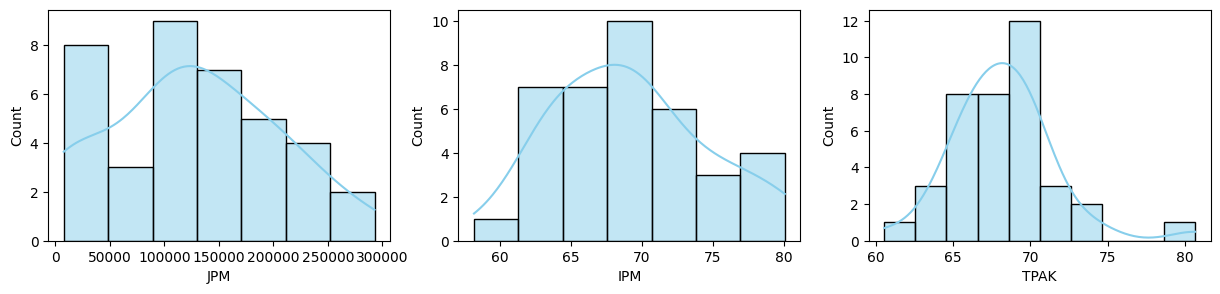

In [5]:
plt.figure(figsize=(15,3))

plt.subplot(1, 3, 1)
sns.histplot(df.JPM, kde=True, color='skyblue')
plt.subplot(1, 3, 2)
sns.histplot(df.IPM, kde=True, color='skyblue')
plt.subplot(1, 3, 3)
sns.histplot(df.TPAK, kde=True, color='skyblue')

# Menampilkan histogram
plt.show()

### Pair Plot

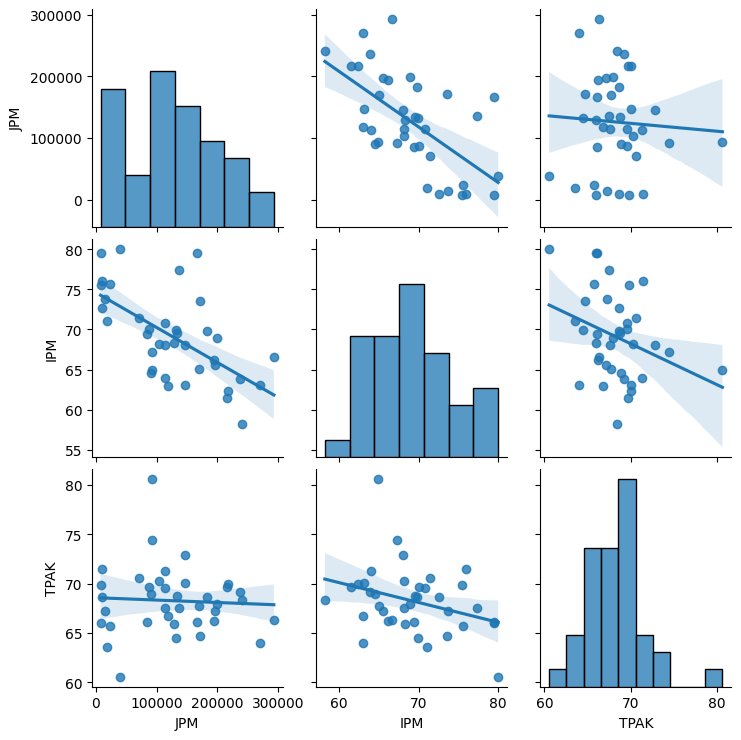

In [6]:
sns.pairplot(df, kind='reg');

### Correlation Matrix

digunakan untuk mengevaluasi hubungan antara dua variabel dalam suatu kumpulan data. Nilai 1 dianggap hubungan antar variabel kuat positif, 0 dianggap tidak ada hubungan, dan -1 dianggap hubungan kuat negatif.

diketahui bahwa kedua variabel merupakan data berskala rasio dan berasal dari dua sumber yang berbeda atau tidak berpasangan sehingga pengujian hipotesis korelasi antar variabel dapat dilakukan menggunakan uji Pearson atau Spearman tergantung dari distribusi data. Jika kedua variabel berdistribusi normal, maka pengujian akan dilakukan menggunakan uji Pearson. Jika tidak, maka akan digunakan uji Spearman.

- Uji Pearson  : statistika parametrik, data berpasangan maupun tidak, harus memenuhi asumsi normalitas, data berskala interval atau rasio
- Uji Spearman : statistika non parametrik, berasal dari sumber yang berbeda atau tidak berpasangan, tidak perlu berdistribusi normal, data berskala interval atau rasio, bisa digunakan untuk data berskala ordinal

sehingga dilakukan uji normalitas untuk masing-masing variabel <br>
H0 : data berdistribusi normal <br>
H1 : data tidak berdistribusi normal

dengan α = 0.05 <br>
tolak H0 jika p-value < α

In [7]:
for i in df.drop(columns=['KaKot']).columns:
    statistic, pvalue = shapiro(df[i])
    print('{} : nilai statistic sebesar: {:.4f}'.format(i, statistic))
    print('{} : nilai pvalue sebesar: {:.4f}'.format(i, pvalue))
    print('keputusan : {}\n'.format(compare(pvalue)))

JPM : nilai statistic sebesar: 0.9635
JPM : nilai pvalue sebesar: 0.2466
keputusan : 0.247 > 0.05, H0 gagal ditolak

IPM : nilai statistic sebesar: 0.9711
IPM : nilai pvalue sebesar: 0.4232
keputusan : 0.423 > 0.05, H0 gagal ditolak

TPAK : nilai statistic sebesar: 0.9238
TPAK : nilai pvalue sebesar: 0.0128
keputusan : 0.013 < 0.05, H0 ditolak



kesimpulan : 
- Nilai p-value untuk data JPM bernilai (0.247) > 0.05 menandakan data JPM **beridistribusi normal**.
- Nilai p-value untuk data IPM bernilai (0.423) > 0.05 menandakan data IPM **beridistribusi normal**. 
- Nilai p-value untuk data TPAK bernilai (0.013) < 0.05 menandakan data TPAK **tidak beridistribusi normal**. 

Karena salah satu variabel tidak berdistribusi normal maka digunakan Uji Korelasi Spearman.

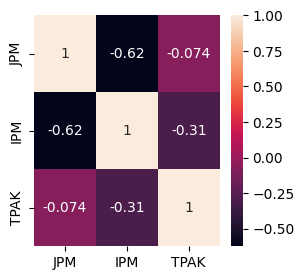

In [8]:
corr_matrix = df.drop(columns=['KaKot']).corr(method='spearman')
plt.figure(figsize=(3,3))
sns.heatmap(corr_matrix, annot=True);

dapat dilihat bahwa :
- Nilai dari Spearman Correlation untuk Indeks Pembangunan Manusia (IPM) terhadap Jumlah Penduduk Miskin (JPM) sebesar -0.63, artinya bahwa hubungan antara IPM dengan JPM **berkorelasi negatif sedang**. Maka, ketika terdapat kenaikan IPM di suatu kabupaten/kota di Jawa Timur akan menyebabkan cukup banyak turunnya Jumlah Penduduk Miskin.
- Nilai dari Spearman Correlation untuk Tingkat Partisipasi Angkatan Kerja (TPAK) terhadap Jumlah Penduduk Miskin (JPM) sebesar -0.074, artinya bahwa hubungan antara IPM dengan JPM **berkorelasi negatif secara lemah**. Maka, ketika terdapat kenaikan TPAK di suatu kabupaten/kota di Jawa Timur akan menyebabkan sedikit turunnya Jumlah Penduduk Miskin.

## Modelling

In [9]:
X = np.array(df[['IPM','TPAK']])
Y = np.array(df['JPM'])

In [10]:
#preview
X[:3]

array([[64.92, 80.64],
       [68.16, 70.24],
       [67.25, 74.43]])

In [11]:
# Perlu ditambahkan nilai konstanta di kolom pertama
X = sm.add_constant(X)
X[:3]

array([[ 1.  , 64.92, 80.64],
       [ 1.  , 68.16, 70.24],
       [ 1.  , 67.25, 74.43]])

In [12]:
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     15.12
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           1.85e-05
Time:                        09:11:22   Log-Likelihood:                -469.40
No. Observations:                  38   AIC:                             944.8
Df Residuals:                      35   BIC:                             949.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.281e+06   2.75e+05      4.662      0.000    7.23e+05    1.84e+06
x1         -1.027e+04   1874.133     -5.480      0.000   -1.41e+04   -6465.583
x2         -6519.5877   2991.075     -2.180      0.036   -1.26e+04    -447.383
==============================================================================
Omnibus:                        1.285   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                0.946
Skew:                           0.384   Prob(JB):                        0.623
Kurtosis:                       2.915   Cond. No.                     2.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Uji Asumsi Klasik
Sebelum dilakukan Uji Hipotesis dan Interpretasi Model, akan dilakukan Uji Asumsi terhadap **residual** model. Uji Asumsi meliputi:
- Asumsi Normalitas
- Asumsi Homoskedastisitas
- Asumsi Non-Autokorelasi
- Asumsi Non-Multikolinearitas

references : https://www.statsmodels.org/stable/diagnostic.html#diagnostics

### Asumsi Normalitas

Tujuan : untuk mengetahui apakah residual data berdistribusi normal atau tidak. <br>
H0 : residual berdistribusi normal <br>
H1 : residual tidak berdistribusi normal

dengan α = 0.05 <br>
tolak H0 jika p-value < α

In [13]:
residuals = model.resid
statistic, pvalue = shapiro(residuals)
print('nilai statistic sebesar: {:.4f}'.format(statistic))
print('nilai pvalue sebesar: {:.4f}'.format(pvalue))

nilai statistic sebesar: 0.9763
nilai pvalue sebesar: 0.5884


diperoleh nilai p-value sebesar 0.5884 > 0.05. 

Artinya, pada taraf signifikansi 5%, H0 gagal ditolak sehingga residual data berdistribusi normal (asumsi normalitas terpenuhi).

### Asumsi Homoskedastisitas

Tujuan : untuk mengetahui apakah varian dari residual konstan atau tidak. <br>
H0 : varian dari residual konstan <br>
H1 : varian dari residual tidak konstan.

dengan α = 0.05 <br>
tolak H0 jika p-value < α

In [14]:
BP, pvalue, _, _ = het_breuschpagan(residuals, X)
print('nilai breusch-pagan sebesar: {:.4f}'.format(BP))
print('nilai pvalue sebesar: {:.4f}'.format(pvalue))

nilai breusch-pagan sebesar: 4.5630
nilai pvalue sebesar: 0.1021


diperoleh nilai p-value sebesar 0.1021 > 0.05. 

Artinya, pada taraf signifikansi 5%, H0 gagal ditolak sehingga varian dari residual model konstan (asumsi homoskedastisitas terpenuhi).

### Asumsi Non-Autokorelasi

Metode pengujian yang sering digunakan adalah dengan uji Durbin-Watson (uji DW) 

dengan hipotesis yang digunakan adalah <br>
H0 : Tidak ada autokorelasi antar residual amatan dan <br>
H1 : Ada autokorelasi antar residual amatan. Adapun kriteria uji yang digunakan adalah sebagai berikut.
- Jika 0 < d < dL maka terdapat autokorelasi positif
- Jika dL < d < dU maka pengujian tidak meyakinkan atau tidak ada kesimpulan yang pasti
- Jika dU < d < 4 - dU maka tidak terdapat autokorelasi
- Jika 4 - dU < d < 4 - dL maka pengujian tidak meyakinkan atau tidak ada kesimpulan yang pasti
- Jika 4 – dL < d < 4 maka terdapat autokorelasi negatif

dengan α = 0.05 <br>
tolak H0 jika p-value < α

Diperoleh nilai DU dan DL dari tabel berikut : <br>
http://repository.unpkediri.ac.id/5725/9/RAMA_61201_18102020014_0706108902_0728068702_07_lamp.pdf

dengan α = 5%, n = 38, k = 3 <br>
DU : 1.6563 <br>
DL : 1.3177

In [15]:
DU = 1.6563
DL = 1.3177

d = durbin_watson(residuals)

print('nilai DU : {:.4f}'.format(DU))
print('nilai DL : {:.4f}'.format(DL))
print('nilai Durbin-Watson : {:.4f}'.format(d))
print('\nkesimpulan :')

if d < DL :
    print('0 < d < DL, terdapat autokorelasi positif')
elif d < DU :
    print('DL < d < DU, pengujian tidak meyakinkan atau tidak ada kesimpulan yang pasti')
elif d < (4-DU) :
    print('DU < d < 4-DU, tidak terdapat autokorelasi')
elif d < (4 - DL) :
    print('4-DU < d < 4-DL, pengujian tidak meyakinkan atau tidak ada kesimpulan yang pasti')
else :
    print('4-DL < d < 4, terdapat autokorelasi negatif')

nilai DU : 1.6563
nilai DL : 1.3177
nilai Durbin-Watson : 1.8878

kesimpulan :
DU < d < 4-DU, tidak terdapat autokorelasi


### Asumsi Non-Multikolinearitas

Pengecekan multikolinieritas pada model akan dilakukan dengan menghitung nilai VIF dari kedua variabel independen. Jika nilai VIF < 10, maka asumsi non-multikolinieritas terpenuhi.

In [16]:
VIF = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print('constant :', round(VIF[0], 3))
print('IPM      :', round(VIF[1], 3))
print('TPAK     :', round(VIF[2], 3))

constant : 841.447
IPM      : 1.114
TPAK     : 1.114


diperoleh nilai VIF untuk semua variabel < 10. <br>
Artinya, tidak ada hubungan antar variabel independen dalam model (asumsi non-multikolinearitas terpenuhi).

### Kesimpulan Uji Asumsi

Dari pengujian keempat asumsi, diperoleh hasil bahwa semua asumsi telah terpenuhi sehingga tahap selanjutnya akan dilanjutkan dengan pembentukan model dan pengujian signifikansi parameter untuk mengetahui ada tidaknya pengaruh Indeks Pembangunan Manusia dan Tingkat Partisipasi Angkatan Kerja terhadap Jumlah Penduduk Miskin di Jawa Timur.

## Estimasi Model

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     15.12
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           1.85e-05
Time:                        09:11:22   Log-Likelihood:                -469.40
No. Observations:                  38   AIC:                             944.8
Df Residuals:                      35   BIC:                             949.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.281e+06   2.75e+05      4.662      0.000    7.23e+05    1.84e+06
x1         -1.027e+04   1874.133     -5.480      0.000   -1.41e+04   -6465.583
x2         -6519.5877   2991.075     -2.180      0.036   -1.26e+04    -447.383
==============================================================================
Omnibus:                        1.285   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                0.946
Skew:                           0.384   Prob(JB):                        0.623
Kurtosis:                       2.915   Cond. No.                     2.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Koefisien regresi untuk masing-masing variabel dapat dilihat pada kolom 'coef' atau 'model dan diperoleh model sebagai berikut.

In [18]:
const = model.params[0]
IPM = model.params[1]
TPAK = model.params[2]

print('model :')
print('JPM_hat = {:,.0f} {} {:,.0f}IPM {} {:,.0f}TPAK'.format(const, sign(TPAK), abs(IPM), sign(TPAK), abs(TPAK)))

model :
JPM_hat = 1,280,961 - 10,270IPM - 6,520TPAK


dari model dapat ditarik kesimpulan :
- Jika semua variabel independen bernilai 0, maka Jumlah Penduduk Miskin akan bernilai sebesar 1,280,961 jiwa.
- Jika Indeks Pembangunan Manusia (IPM) naik 1 persen, maka Jumlah Penduduk Miskin akan turun sebesar 10,270 jiwa dengan asumsi variabel independen lainnya bernilai tetap.
- Jika Tingkat Partisipasi Angkatan Kerja (TPAK) naik 1 persen, maka Jumlah Penduduk Miskin akan turun sebesar 6,520 jiwa dengan asumsi variabel independen lainnya bernilai tetap

## Uji Signifikansi

### Uji-F

H0: Tidak ada pengaruh variabel independen terhadap variabel dependen
secara bersama-sama (model tidak cocok/signifikan) <br>
H1: Ada pengaruh variabel independen terhadap variabel dependen secara
bersama-sama (model cocok/signifikan)

dengan α = 0.05 <br>
tolak H0 jika p-value < α

In [19]:
print('nilai p-value dari F-statistic : {:.3f}'.format(model.f_pvalue))
print('nilai F-statistic : {:.3f}'.format(model.fvalue))

nilai p-value dari F-statistic : 0.000
nilai F-statistic : 15.117


Dari output di atas diperoleh nilai p-value sebesar 0.000 < 0.05. Artinya, pada taraf signifikansi 5%, H0 ditolak sehingga model signifikan. Atau dapat diartikan bahwa ada pengaruh variabel independen terhadap variabel dependen secara bersama-sama.

### Uji-t

tujuan : untuk mengetahui variabel independen yang signifikan berpengaruh terhadap Jumlah Penduduk Miskin.

H0: variabel independen tidak berpengaruh signifikan terhadap variabel
dependen <br>
H1: variabel independen berpengaruh signifikan terhadap variabel dependen

dengan α = 0.05 <br>
tolak H0 jika p-value < α

In [20]:
result = [compare(i, 0.05) for i in model.pvalues]
array = np.array([(model.tvalues), model.pvalues, result]).T
pd.DataFrame(array, index=['const', 'IPM', 'TPAK'], columns=['t-stat', 'p-value', 'result'])

,t-stat,p-value,result
const,4.662416698293238,4.42837783514149e-05,"0.000 < 0.05, H0 ditolak"
IPM,-5.480013619585639,3.7448115439164903e-06,"0.000 < 0.05, H0 ditolak"
TPAK,-2.17968066854959,0.0360964638105075,"0.036 < 0.05, H0 ditolak"


Berdasarkan kolom result di atas dapat ditarik kesimpulan:
- Indeks Pembangunan Manusia memiliki nilai p-value sebesar 0.000 < 0.05. Artinya, pada taraf signifikansi 5%, H0 ditolak sehingga terdapat pengaruh Indeks Pembangunan Manusia terhadap Jumlah Penduduk Miskin. Adapun pengaruh tersebut memiliki arah negatif (-5.48).
- Tingkat Partisipasi Angkatan Kerja memiliki nilai p-value sebesar 0.036 < 0.05. Artinya, pada taraf signifikansi 5%, H0 ditolak sehingga terdapat pengaruh Tingkat Partisipasi Angkatan Kerja terhadap Jumlah Penduduk Miskin. Adapun pengaruh tersebut juga memiliki arah negatif (-2.18).

## Koefisien Determinasi

In [21]:
print('nilai Adjusted R-Squared : {:.2%}'.format(model.rsquared_adj))

nilai Adjusted R-Squared : 43.28%


Nilai koefisien determinasi yang diperoleh sebesar 0.4328 (Adjusted R-Squared). Artinya, Jumlah Penduduk Miskin dipengaruhi oleh semua variabel independen dalam penelitian sebesar 43.28% dan sisanya 56.72% dipengaruhi oleh faktor lain di luar penelitian.